<h1>COSC 74 Final Project</h1>
<p>Author: Ben Lehrburger (benjamin.f.lehrburger.23@dartmouth.edu)</p>
<h3>Binary Classification, Multiclass Classification, and Clustering Analysis</h3> 

In [90]:
# Dependencies
import pandas as pd
import sklearn as sk
import autograd.numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import silhouette_score
from sklearn.metrics import rand_score
from sklearn.cluster import KMeans

# Hugging Face
from transformers import pipeline

<h2>Feature Engineering</h2>

Before building classification models, we need to know which features of our data might actually hold predictive value. Our target is the overall score of the review, so we should look at whether other data features correlate with that variable.

In [3]:
# Read in test and train datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style,category
0,1,False,"11 12, 2016",C413C78E10E54C5DB41837889F36C1E8,565D194F38B1CC3F806EE677C61F639C,465E154EC79AFFAB5EB2607198B21433,all of the reviews for this product are fake.,"All fake reviews, beware.",1478908800,2.0,NaN,{'Size:': ' Polaris H4'},automotive
1,1,True,"12 6, 2016",490AE37808EFEE3AF4FE6DEBDEB5A4C8,0D66512A0A7F580523AB996378DF0F14,760C63E8E5E8DC3FAA01878D37BA5678,wrong part. our fault.,One Star,1480982400,NaN,NaN,NaN,automotive
2,1,True,"09 17, 2014",74A9FA5A64449BEE2A2E8E3F62872F0F,A0E45600FF2C5A779CB4314F379C253A,C6E4DD5C1C4EC09E90182644ED6CA9EF,this wire set it really sucks!!!,One Star,1410912000,NaN,NaN,NaN,automotive
3,1,True,"06 11, 2016",EB561158A2829D98B467FE03CC1E45F1,37AB9A82470595E0ACB88BAC48C150EE,F4892A77EA45C52F40AB17ED537EF9FF,"first use, it leaked instantly. even at 5 buck...",One Star,1465603200,NaN,NaN,"{'Color:': ' Clear', 'Style:': ' 45 Degree'}",automotive
4,1,True,"12 23, 2017",5045D801332850D21618DD13A697CD9B,5772FF30428EEB8E0258C1A53CA2EC50,522F0BBFF2B47F1D63FF781A0AB1D079,didn't fit,One Star,1513987200,NaN,NaN,NaN,automotive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29184,5,True,"03 20, 2015",24A0B29940152C574DA401347CE47E7A,CD83ED06223FE876323282B57209D765,1B5F1A160CB115EB26D0651E5BF59BE9,this is the same plush toy that the official d...,"Well constructed, very soft",1426809600,NaN,NaN,NaN,toys
29185,5,True,"05 15, 2014",AD3FD1D6499FA73ACBCBB39F89EE5BF9,3625ADD67F860057FD15B71FD0389264,C8DC85A8F6B8527735AF7FA6182BB209,"my grandson loved this. it is a great toy, he ...",Fun toy,1400112000,NaN,NaN,NaN,toys
29186,5,True,"11 13, 2017",24C8C33C6FD8ACCAFE2EC1D1FC4DBF05,0C0DF58B2AC0350731C4146D32DBD3F0,951CEFD3CA5CB6773251E773379FF26A,my kiddo loves them! we are a rock climbing fa...,and now the play set has a nice climbing feature,1510531200,NaN,NaN,NaN,toys
29187,5,True,"01 2, 2018",E313EE1C17E5E553343F50BBC95BB2C2,9C9D7AAF41631F1096FE10FBA18B6029,F5A4D2A1C2A0CAD7BBC378CB10CB410C,i bought this for my niece (age 2) and mailed ...,my brother said she liked it and I haven't see...,1514851200,NaN,NaN,{'Style:': ' Standard Version'},toys


In [4]:
# Get the average ratings for each category

category_dict={}

for index, row in train.iterrows():
    
    c = row['category']
    o = row['overall']
    
    if c in category_dict.keys():
        category_dict[c][0] += o
        category_dict[c][1] += 1
        
    else:
        category_dict[c] = [o, 1]
        
y = []
x = list(category_dict.keys())

for key, value in category_dict.items():
    y.append(value[0] / value[1])

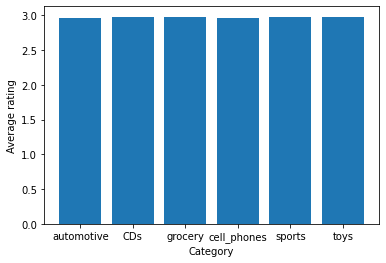

In [5]:
# Visualize average ratings vs. category

plt.bar(x, y)
plt.ylabel('Average rating'), plt.xlabel('Category')
plt.show()

I wanted to see if different product categories were, on average, rated higher or lower than others. If there was a significant difference, then we would want to include the category feature in our training set. However, each category had roughly the same average ratings.

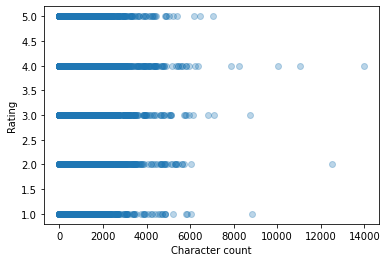

In [6]:
# Visualize review length vs. rating

length = []

for index, row in train.iterrows():
    length.append(len(row['reviewText']))
    
plt.scatter(length, list(train['overall']), alpha=0.3)
plt.ylabel('Rating'), plt.xlabel('Character count')
plt.show()

The next potentially useful data feature that I wanted to look at was the written review under the 'reviewText' category. I wondered whether the length of a review might indicate its rating. Perhaps people that like a product more (or less) decide to write more about it. However, as the figure above shows, this is not the case.

Instead, the only data feature that I found to be indicative of product rating was the contents of the product review. High product ratings had positively-valenced reviews written about them, while low product ratings came with negatively-valenced reviews. So, I performed some natural language processing, building a sparse matrix of word counts to replace each review. This served as my input data. The label for each input was that product's rating.

In [7]:
# Build a sparse matrix of word counts as input X
cv = CountVectorizer()
x = cv.fit_transform(train['reviewText'])

# Make y values the product ratings
y = train['overall']

# Split the dataset into training and testing phases
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

<h2>Binary Classification</h2>

In [42]:
# Define a binary classifier object
# Parameters: train and test datasets, classification cutoff, learning rate, maximum training iterations
class BinaryClassifier():
    
    def __init__(self, x_train, x_test, y_train, y_test, threshold, alpha, max_its, reg):
        
        self.threshold = threshold
        self.alpha = alpha
        self.max_its = max_its
        self.reg = reg
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = self.binary_encode(y_train)
        self.y_test = self.binary_encode(y_test)
        self.model = None
        self.predictions = None
        self.accuracy = None
        self.f1 = None
        self.auc = None
        
    # Convert product ratings into binary
    # Make anything above the threshold 1 and anything below it or equal to it 0
    def binary_encode(self, predictions):
    
        encoded = []
    
        for i in predictions:
            
            if i <= self.threshold:
                encoded.append(0)
            else:
                encoded.append(1)

        return encoded
    
    # Build a logistic regression model using sklearn
    def logistic_regression(self):
        
        if self.reg == 'l1':
            lr = LogisticRegression(max_iter=self.max_its, C=self.alpha, penalty=self.reg, solver='liblinear').fit(self.x_train, self.y_train)
        else:
            lr = LogisticRegression(max_iter=self.max_its, C=self.alpha, penalty=self.reg).fit(self.x_train, self.y_train)

        self.model = lr
        
        return lr
    
    # Predict whether the rating of a product review is above or below the threshold
    def predict(self):
        
        self.predictions = self.model.predict(self.x_test)
        
        return self.predictions

    # Evaluate the performance of the classifier
    def evaluate(self, final=False):
        
        c_matrix = confusion_matrix(self.y_test, self.predictions)
        self.accuracy = accuracy_score(self.y_test, self.predictions)
        self.auc = roc_auc_score(self.y_test, self.predictions)
        self.f1 = f1_score(self.y_test, self.predictions)
        
        print('The model performs binary classification using logistic regression')
        print('Its hyperparameters are: alpha=' + str(self.alpha) + ', max_iterations=' + str(self.max_its) + ', regularization=' + str(self.reg) + ', threshold=' + str(self.threshold))
        print('\nThe accuracy of this model is: ' + str(self.accuracy))
        print('The Macro F1 score for this model is: ' + str(self.f1))
        print('The confusion matrix for this model is:\n\n', c_matrix)
        print('\nThe AUC of the ROC curve is: ' + str(self.auc))
        print('The ROC curve for this model is: ')
        
        roc_plot = RocCurveDisplay.from_predictions(self.y_test, self.predictions)
        
    def run(self):
        
        self.logistic_regression()
        self.predict()
        self.evaluate()
        

In [ ]:
def cross_validate(m1, m2, m3):
    
    m1_score = round(np.mean(cross_val_score(m1.model, x_test, y_test)), 3)
    m2_score = round(np.mean(cross_val_score(m2.model, x_test, y_test)), 3)
    m3_score = round(np.mean(cross_val_score(m3.model, x_test, y_test)), 3)
    
    x = ['Model 1', 'Model 2', 'Model 3']
    y = [m1_score, m2_score, m3_score]
    plt.bar(x, y)
    
    for i in range(3):
        plt.text(i, y[i]/2, y[i], ha='center')
        
    plt.title('5-Fold Cross Validation Comparison')
    plt.ylabel('Cross Validation Score')
    plt.show()

<h3>Cutoff = 1</h3>

<h5>Cutoff = 1, Model 1</h5>

The model performs binary classification using logistic regression
Its hyperparameters are: alpha=1.0, max_iterations=1000, regularization=l2, threshold=1

The accuracy of this model is: 0.828879753340185
The Macro F1 score for this model is: 0.8960566018104255
The confusion matrix for this model is:

 [[ 533  642]
 [ 357 4306]]

The AUC of the ROC curve is: 0.6885284334347809
The ROC curve for this model is: 


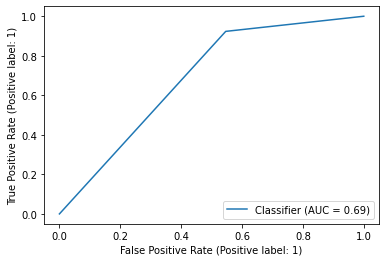

In [41]:
threshold = 1
alpha = 1.0
max_its = 1000
regularization = 'l2'

model11 = BinaryClassifier(x_train, x_test, y_train, y_test, threshold, alpha, max_its, regularization)
model11.run()

<h5>Cutoff = 1, Model 2</h5>

The model performs binary classification using logistic regression
Its hyperparameters are: alpha=0.1, max_iterations=1000, regularization=l2, threshold=1

The accuracy of this model is: 0.8355601233299075
The Macro F1 score for this model is: 0.9024191908924579
The confusion matrix for this model is:

 [[ 439  736]
 [ 224 4439]]

The AUC of the ROC curve is: 0.6627896386674637
The ROC curve for this model is: 


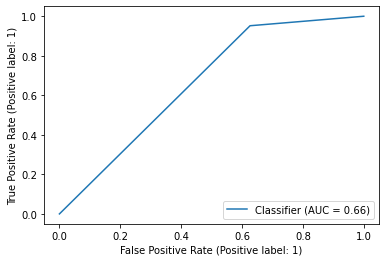

In [49]:
threshold = 1
alpha = 0.1
max_its = 1000
regularization = 'l2'

model12 = BinaryClassifier(x_train, x_test, y_train, y_test, threshold, alpha, max_its, regularization)
model12.run()

<h5>Cutoff = 1, Model 3</h5>

The model performs binary classification using logistic regression
Its hyperparameters are: alpha=0.1, max_iterations=2000, regularization=l1, threshold=1

The accuracy of this model is: 0.8328194587187393
The Macro F1 score for this model is: 0.9024780175859313
The confusion matrix for this model is:

 [[ 346  829]
 [ 147 4516]]

The AUC of the ROC curve is: 0.6314716578223316
The ROC curve for this model is: 


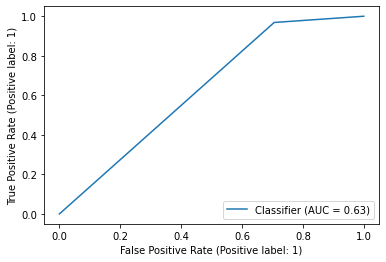

In [46]:
threshold = 1
alpha = 0.1
max_its = 2000
regularization = 'l1'

model13 = BinaryClassifier(x_train, x_test, y_train, y_test, threshold, alpha, max_its, regularization)
model13.run()

<h5>Hyperparameter Tuning</h5>

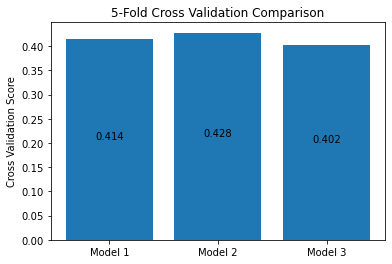

In [48]:
# Conduct 5-fold cross-validation
# Visualize and compare cross-validation scores

cross_validate(model11, model12, model13)

I built three different models to see how different hyperparameters impact classifier performance. Cross-validation reveals that an alpha of 0.1 performs better than an alpha of 1.0. A learning rate of 1.0 likely results in steps that are too big to capture the local minimum. Increasing the maximum number of training iterations had no effect on the classifier's performance. It is likely that the model's parameters are already sufficiently trained after 1000 training iterations. L1 regularization hindered the classifier's performance, meaning that L2 regularization performs better on this model. Thus, the hyperparameters of the final model are alpha=0.1, max_its=1000, and regularization=L2.

<h5>Cutoff = 1, Final Model</h5>

The model performs binary classification using logistic regression
Its hyperparameters are: alpha=0.1, max_iterations=1000, regularization=l2, threshold=1

The accuracy of this model is: 0.8355601233299075
The Macro F1 score for this model is: 0.9024191908924579
The confusion matrix for this model is:

 [[ 439  736]
 [ 224 4439]]

The AUC of the ROC curve is: 0.6627896386674637
The ROC curve for this model is: 


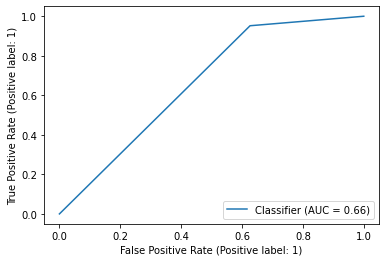

In [50]:
threshold = 1
alpha = 0.1
max_its = 1000
regularization = 'l2'

final_model1 = BinaryClassifier(x_train, x_test, y_train, y_test, threshold, alpha, max_its, regularization)
final_model1.run()

<h3>Cutoff = 2</h3>

<h5>Cutoff = 2, Model 1</h5>

The model performs binary classification using logistic regression
Its hyperparameters are: alpha=0.5, max_iterations=500, regularization=l2, threshold=2

The accuracy of this model is: 0.7781774580335732
The Macro F1 score for this model is: 0.8182966184930546
The confusion matrix for this model is:

 [[1627  730]
 [ 565 2916]]

The AUC of the ROC curve is: 0.7639872892629935
The ROC curve for this model is: 


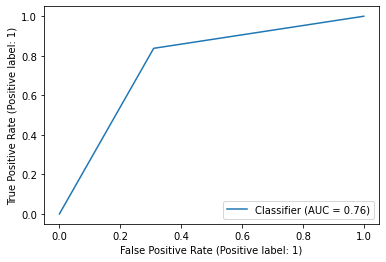

In [53]:
threshold = 2
alpha = 0.5
max_its = 500
regularization = 'l2'

model21 = BinaryClassifier(x_train, x_test, y_train, y_test, threshold, alpha, max_its, regularization)
model21.run()

<h5>Cutoff = 2, Model 2</h5>

The model performs binary classification using logistic regression
Its hyperparameters are: alpha=0.1, max_iterations=500, regularization=l2, threshold=2

The accuracy of this model is: 0.7773210003425831
The Macro F1 score for this model is: 0.8202433628318583
The confusion matrix for this model is:

 [[1572  785]
 [ 515 2966]]

The AUC of the ROC curve is: 0.75950175978038
The ROC curve for this model is: 


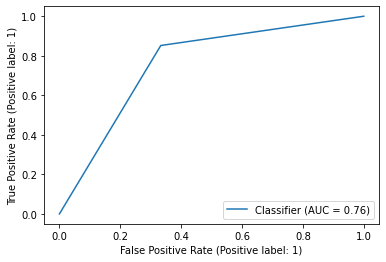

In [54]:
threshold = 2
alpha = 0.1
max_its = 500
regularization = 'l2'

model22 = BinaryClassifier(x_train, x_test, y_train, y_test, threshold, alpha, max_its, regularization)
model22.run()

<h5>Cutoff = 2, Model 3</h5>

The model performs binary classification using logistic regression
Its hyperparameters are: alpha=0.5, max_iterations=1000, regularization=l1, threshold=2

The accuracy of this model is: 0.7747516272696129
The Macro F1 score for this model is: 0.8163151278111468
The confusion matrix for this model is:

 [[1601  756]
 [ 559 2922]]

The AUC of the ROC curve is: 0.7593336247916899
The ROC curve for this model is: 


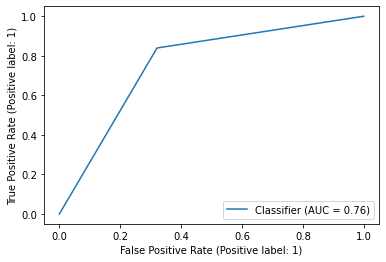

In [57]:
threshold = 2
alpha = 0.5
max_its = 1000
regularization = 'l1'

model23 = BinaryClassifier(x_train, x_test, y_train, y_test, threshold, alpha, max_its, regularization)
model23.run()

<h5>Hyperparameter Tuning</h5>

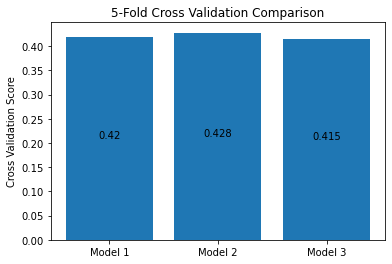

In [58]:
# Conduct 5-fold cross-validation
# Visualize and compare cross-validation scores

cross_validate(model21, model22, model23)

After cross-validating the three models I made with a cutoff of 2, it appears that an alpha of 0.1 best fits the data. Although an alpha of 0.5 actually results in slightly better accuracy, an alpha of 0.1 performs better across all 5 cross validation metrics. As for the maximum number of training iterations, there was no difference in performance when max was dropped from 1000 to 500. Lastly, changing regularization from L2 to L1 caused performance to suffer across the board in model 3. Therefore, the hyperparameters of the final model ought to be alpha=0.1, max_its=500, and regularization=L2.

<h5>Cutoff = 2, Final Model</h5>

The model performs binary classification using logistic regression
Its hyperparameters are: alpha=0.1, max_iterations=500, regularization=l2, threshold=2

The accuracy of this model is: 0.7773210003425831
The Macro F1 score for this model is: 0.8202433628318583
The confusion matrix for this model is:

 [[1572  785]
 [ 515 2966]]

The AUC of the ROC curve is: 0.75950175978038
The ROC curve for this model is: 


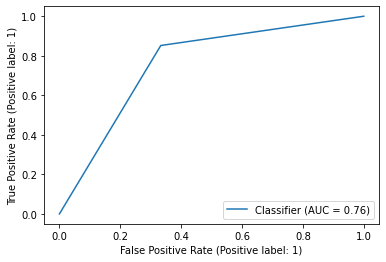

In [60]:
threshold = 2
alpha = 0.1
max_its = 500
regularization = 'l2'

final_model2 = BinaryClassifier(x_train, x_test, y_train, y_test, threshold, alpha, max_its, regularization)
final_model2.run()

<h3>Cutoff = 3</h3>

<h5>Cutoff = 3, Model 1</h5>

The model performs binary classification using logistic regression
Its hyperparameters are: alpha=0.5, max_iterations=500, regularization=l2, threshold=3

The accuracy of this model is: 0.8124357656731758
The Macro F1 score for this model is: 0.7522063815342839
The confusion matrix for this model is:

 [[3081  493]
 [ 602 1662]]

The AUC of the ROC curve is: 0.7980791286104393
The ROC curve for this model is: 


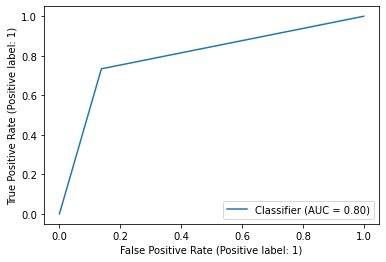

In [62]:
threshold = 3
alpha = 0.5
max_its = 500
regularization = 'l2'

model31 = BinaryClassifier(x_train, x_test, y_train, y_test, threshold, alpha, max_its, regularization)
model31.run()

<h5>Cutoff = 3, Model 2</h5>

The model performs binary classification using logistic regression
Its hyperparameters are: alpha=0.1, max_iterations=500, regularization=l2, threshold=3

The accuracy of this model is: 0.8177458033573142
The Macro F1 score for this model is: 0.7538176770013884
The confusion matrix for this model is:

 [[3145  429]
 [ 635 1629]]

The AUC of the ROC curve is: 0.799744696186237
The ROC curve for this model is: 


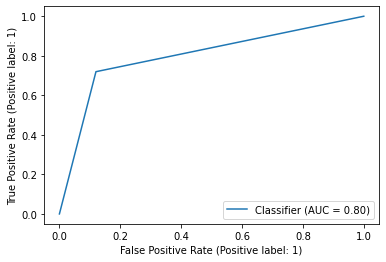

In [63]:
threshold = 3
alpha = 0.1
max_its = 500
regularization = 'l2'

model32 = BinaryClassifier(x_train, x_test, y_train, y_test, threshold, alpha, max_its, regularization)
model32.run()

<h5>Cutoff = 3, Model 3</h5>

The model performs binary classification using logistic regression
Its hyperparameters are: alpha=0.1, max_iterations=500, regularization=l1, threshold=3

The accuracy of this model is: 0.803186022610483
The Macro F1 score for this model is: 0.7261025029797378
The confusion matrix for this model is:

 [[3166  408]
 [ 741 1523]]

The AUC of the ROC curve is: 0.7792726869163036
The ROC curve for this model is: 


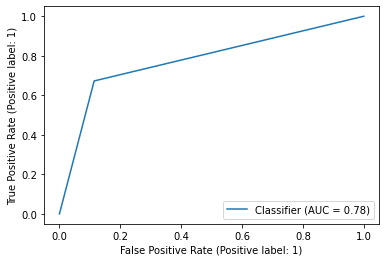

In [67]:
threshold = 3
alpha = 0.1
max_its = 500
regularization = 'l1'

model33 = BinaryClassifier(x_train, x_test, y_train, y_test, threshold, alpha, max_its, regularization)
model33.run()

<h5>Hyperparameter Tuning</h5>

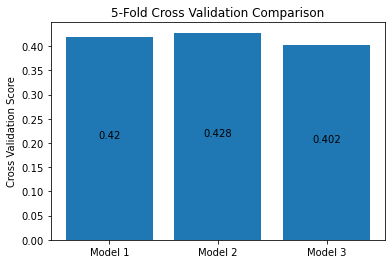

In [68]:
# Conduct cross-validation
# Visualize and compare accuracy, F1 score, and AUC score

cross_validate(model31, model32, model33)

With a cutoff of 3, the models' performance were more susceptible to changes in alpha. An alpha of 0.1 yielded higher accuracy, higher F1, and higher AUC than an alpha of 0.5. An alpha of 0.05 was too low – the step size was too small to reach a local minimum at 500 training iterations. Regularization favored L2; L1 regularization hindered metrics across the board. So the final model's hyperparameters should be alpha=0.1, max_its=500, and regularization=L2.

<h5>Cutoff = 3, Final Model</h5>

The model performs binary classification using logistic regression
Its hyperparameters are: alpha=0.1, max_iterations=500, regularization=l2, threshold=3

The accuracy of this model is: 0.8177458033573142
The Macro F1 score for this model is: 0.7538176770013884
The confusion matrix for this model is:

 [[3145  429]
 [ 635 1629]]

The AUC of the ROC curve is: 0.799744696186237
The ROC curve for this model is: 


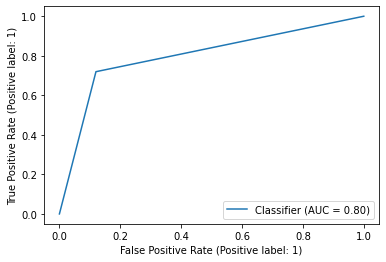

In [69]:
threshold = 3
alpha = 0.1
max_its = 500
regularization = 'l2'

final_model3 = BinaryClassifier(x_train, x_test, y_train, y_test, threshold, alpha, max_its, regularization)
final_model3.run()

<h3>Cutoff = 4</h3>

<h5>Cutoff = 4, Model 1</h5>

The model performs binary classification using logistic regression
Its hyperparameters are: alpha=1.0, max_iterations=500, regularization=l2, threshold=4

The accuracy of this model is: 0.8494347379239465
The Macro F1 score for this model is: 0.5598397596394592
The confusion matrix for this model is:

 [[4400  316]
 [ 563  559]]

The AUC of the ROC curve is: 0.7156057657853797
The ROC curve for this model is: 


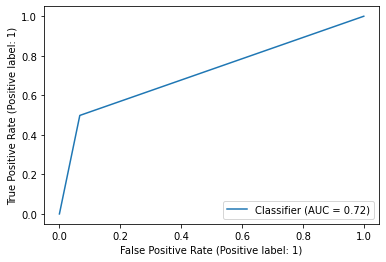

In [70]:
threshold = 4
alpha = 1.0
max_its = 500
regularization = 'l2'

model41 = BinaryClassifier(x_train, x_test, y_train, y_test, threshold, alpha, max_its, regularization)
model41.run()

<h5>Cutoff = 4, Model 2</h5>

The model performs binary classification using logistic regression
Its hyperparameters are: alpha=0.5, max_iterations=500, regularization=l2, threshold=4

The accuracy of this model is: 0.8489208633093526
The Macro F1 score for this model is: 0.544891640866873
The confusion matrix for this model is:

 [[4428  288]
 [ 594  528]]

The AUC of the ROC curve is: 0.7047597665020207
The ROC curve for this model is: 


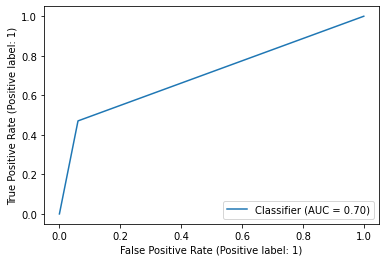

In [71]:
threshold = 4
alpha = 0.5
max_its = 500
regularization = 'l2'

model42 = BinaryClassifier(x_train, x_test, y_train, y_test, threshold, alpha, max_its, regularization)
model42.run()

<h5>Cutoff = 4, Model 3</h5>

The model performs binary classification using logistic regression
Its hyperparameters are: alpha=0.1, max_iterations=500, regularization=l1, threshold=4

The accuracy of this model is: 0.8355601233299075
The Macro F1 score for this model is: 0.37500000000000006
The confusion matrix for this model is:

 [[4590  126]
 [ 834  288]]

The AUC of the ROC curve is: 0.6149834673633507
The ROC curve for this model is: 


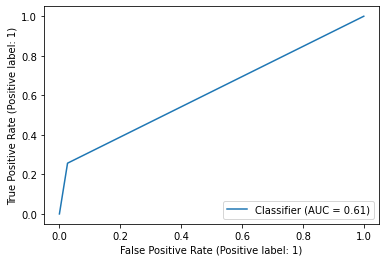

In [74]:
threshold = 4
alpha = 0.1
max_its = 500
regularization = 'l1'

model43 = BinaryClassifier(x_train, x_test, y_train, y_test, threshold, alpha, max_its, regularization)
model43.run()

<h5>Hyperparameter Tuning</h5>

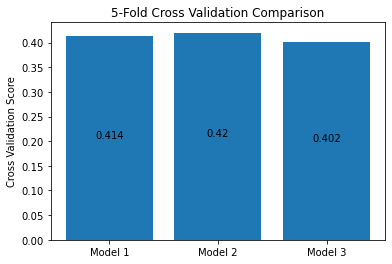

In [75]:
# Conduct cross-validation
# Visualize and compare accuracy, F1 score, and AUC score

cross_validate(model41, model42, model43)

In the previous binary classifiers, I noticed that the model converges well before 500 iterations (unless the learning rate is too small), so I chose to hold the maximum number of training iterations constant at 500. The hyperparameter in question here is alpha. Cross-validation reveals that a learning rate of 0.1 is too low, yielding lower accuracy, F1, and AUC than a learning rate of 1.0 and 0.5. A learning rate of 1.0 does result in higher accuracy than a learning rate of 0.5, but does not perform as well across all 5 cross validation metrics. So, 0.5 is a better choice for this model. As for regularization, when the penalty changes from L2 to L1, Macro F1 score suffers dramatically. Thus, the hyperparameters of the final model should be alpha=0.5, max_its=500, and regularization=L2.

<h5>Cutoff = 4, Final Model</h5>

The model performs binary classification using logistic regression
Its hyperparameters are: alpha=0.5, max_iterations=500, regularization=l2, threshold=4

The accuracy of this model is: 0.8489208633093526
The Macro F1 score for this model is: 0.544891640866873
The confusion matrix for this model is:

 [[4428  288]
 [ 594  528]]

The AUC of the ROC curve is: 0.7047597665020207
The ROC curve for this model is: 


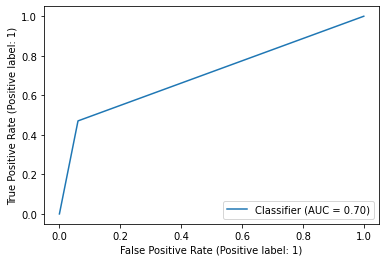

In [77]:
threshold = 4
alpha = 0.5
max_its = 500
regularization = 'l2'

final_model4 = BinaryClassifier(x_train, x_test, y_train, y_test, threshold, alpha, max_its, regularization)
final_model4.run()

<h2>Multiclass Classifier</h2>

In [85]:
# Define a multiclass classifier object
# Parameters: train and test datasets, learning rate, maximum training iterations
class MultiClassClassifier():
    
    def __init__(self, x_train, x_test, y_train, y_test, alpha, max_its, reg):
        
        self.alpha = alpha
        self.max_its = max_its
        self.reg = reg
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = None
        self.predictions = None
        self.auc = None
        self.accuracy = None
        self.f1 = None
        
    # Build a logistic regression model using sklearn
    def logistic_regression(self):
        
        if self.reg == 'l1':
            lr = LogisticRegression(max_iter=self.max_its, C=self.alpha, penalty=self.reg, solver='liblinear').fit(self.x_train, self.y_train)
        else:
            lr = LogisticRegression(max_iter=self.max_its, C=self.alpha, penalty=self.reg).fit(self.x_train, self.y_train)
        
        self.model = lr
        
        return lr
    
    # Predict the rating of a product review
    def predict(self):
        
        self.predictions = self.model.predict(self.x_test)
        
        return self.predictions
    
    # Represent a review's overall score as a one-hot encoded vector
    def one_hot_encode(self, data):
    
        encoded = []

        for dp in data:

            row = [0.0, 0.0, 0.0, 0.0, 0.0]
            row[dp - 1] = 1.0
            encoded.append(row)

        return np.array(encoded)
    
    # Make the positive class equal to 1 and the negative classes equal to 0
    def binary_encode(self, values, target):
    
        for j in range(len(values)):

            if values[j] == target:
                values[j] = 1.0

            else:
                values[j] = 0.0

        return values

    # Evaluate the performance of the classifier
    def evaluate(self):
                
        c_matrix = confusion_matrix(self.y_test, self.predictions)
        self.accuracy = accuracy_score(self.y_test, self.predictions)

        one_hot_encoded_actual = self.one_hot_encode(self.y_test)
        one_hot_encoded_prediction = self.one_hot_encode(self.predictions)

        self.f1 = f1_score(one_hot_encoded_actual, one_hot_encoded_prediction, average='macro', labels=np.unique(one_hot_encoded_prediction))
        
        print('The model performs multiclass classification using logistic regression')
        print('Its hyperparameters are: alpha=' + str(self.alpha) + ', max_iterations=' + str(self.max_its) + ', regularization=' + str(self.reg))
        print('\nThe accuracy of this model is: ' + str(self.accuracy))
        print('The Macro F1 score for this model is: ' + str(self.f1))

        print('The confusion matrix for this model is:\n\n', c_matrix)
        print('\nThe ROC curves for this model and their corresponding AUCs are: ')
        
        auc_tracker = []

        for i in range(1, len(c_matrix[0]) + 1):
        
            actual = self.binary_encode(list(self.y_test.copy()), i)
            predictions = self.binary_encode(list(self.predictions.copy()), i)

            roc_plot = RocCurveDisplay.from_predictions(actual, predictions)            
            auc_tracker.append(roc_plot.roc_auc)
            
            plt.title('Positive class = {x}'.format(x=i))
            plt.show()
                    
        self.auc = np.mean(auc_tracker)
        
        print('The mean AUC across all positive classes is: ' + str(self.auc))
        
    def run(self):
        
        self.logistic_regression()
        self.predict()
        self.evaluate()

<h5>Model 1</h5>

The model performs multiclass classification using logistic regression
Its hyperparameters are: alpha=0.5, max_iterations=1000, regularization=l2

The accuracy of this model is: 0.4576909900650908
The Macro F1 score for this model is: 0.4481898515584458
The confusion matrix for this model is:

 [[694 261 123  49  48]
 [348 368 298 107  61]
 [150 270 437 251 109]
 [ 51  99 222 432 338]
 [ 38  42  96 205 741]]

The ROC curves for this model and their corresponding AUCs are: 


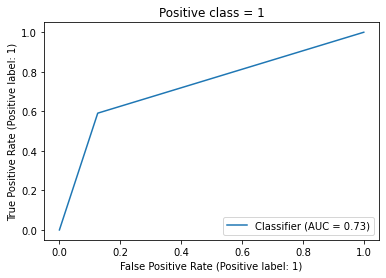

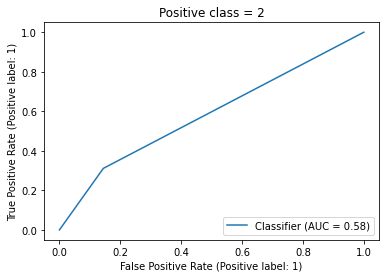

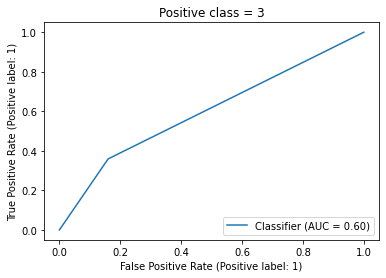

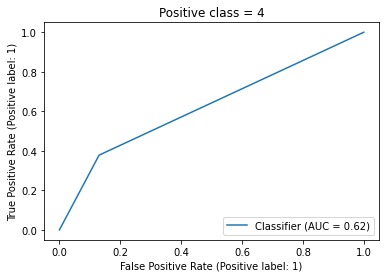

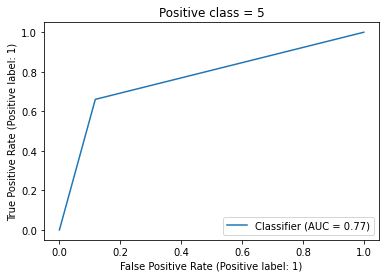

The mean AUC across all positive classes is: 0.6621409422233427


In [86]:
alpha = 0.5
max_its = 1000
regularization = 'l2'

model1 = MultiClassClassifier(x_train, x_test, y_train, y_test, alpha, max_its, regularization)
model1.run()

<h5>Model 2</h5>

The model performs multiclass classification using logistic regression
Its hyperparameters are: alpha=0.1, max_iterations=1000, regularization=l2

The accuracy of this model is: 0.4684823569715656
The Macro F1 score for this model is: 0.4565145370423259
The confusion matrix for this model is:

 [[713 241 106  50  65]
 [354 378 286  87  77]
 [169 269 434 224 121]
 [ 52  87 217 437 349]
 [ 38  48  78 185 773]]

The ROC curves for this model and their corresponding AUCs are: 


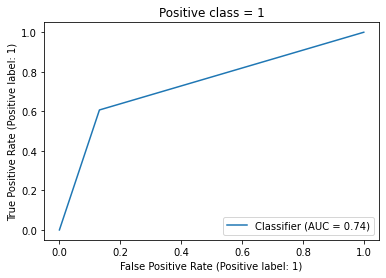

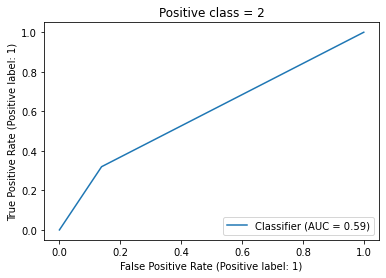

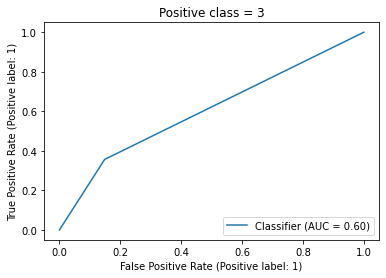

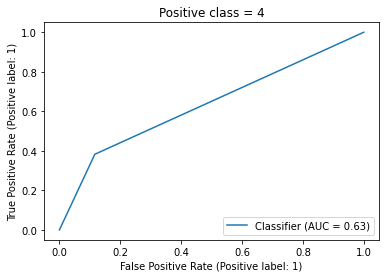

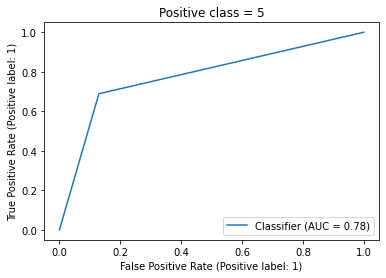

The mean AUC across all positive classes is: 0.669012975629133


In [87]:
alpha = 0.1
max_its = 1000
regularization = 'l2'

model2 = MultiClassClassifier(x_train, x_test, y_train, y_test, alpha, max_its, regularization)
model2.run()

<h5>Model 3</h5>

The model performs multiclass classification using logistic regression
Its hyperparameters are: alpha=0.1, max_iterations=2000, regularization=l1

The accuracy of this model is: 0.4552929085303186
The Macro F1 score for this model is: 0.4427984816813455
The confusion matrix for this model is:

 [[760 177  78  43 117]
 [410 324 220 107 121]
 [193 242 379 229 174]
 [ 68  88 200 390 396]
 [ 53  51  59 154 805]]

The ROC curves for this model and their corresponding AUCs are: 


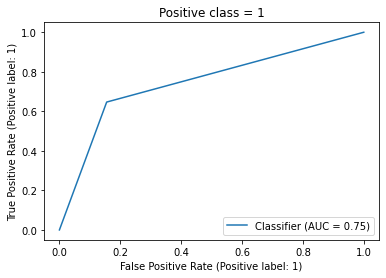

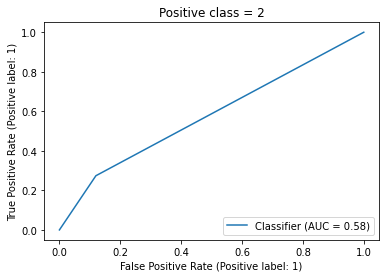

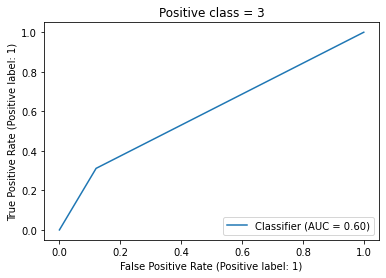

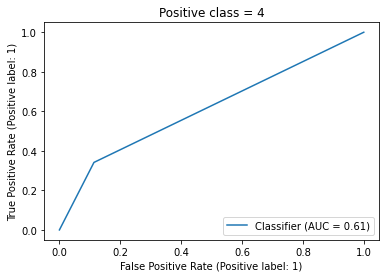

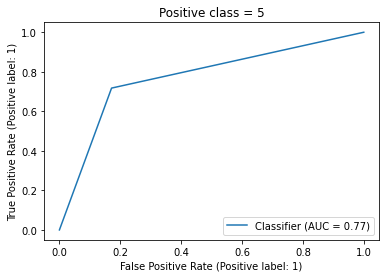

The mean AUC across all positive classes is: 0.6610837268494372


In [88]:
alpha = 0.1
max_its = 2000
regularization = 'l1'

model3 = MultiClassClassifier(x_train, x_test, y_train, y_test, alpha, max_its, regularization)
model3.run()

<h5>Hyperparameter Tuning</h5>

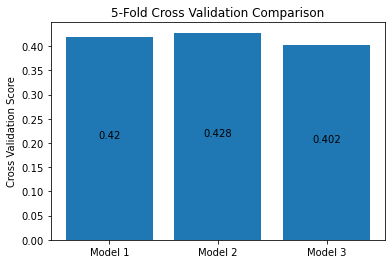

In [83]:
# Conduct cross-validation
# Visualize and compare accuracy, F1 score, and AUC score

cross_validate(model1, model2, model3)

I varied the learning rate, number of training iterations, and regularization to find the optimal combination of hyperparameters. First I tried a learning rate of 1.0 but the step size was too big to narrow in on a local minimum, so I omitted the model. Model 1 has a learning rate of 0.5, which had poorer accuracy, macro F1, and AUC scores than Model 2, with its learning rate of 0.1. This hints that smaller learning rates are necessary to build an approach towards a local minimum on the error surface. I did experiment with learning rates lower than 0.1, but the model's ability to converge suffered. Next, I held learning rate constant at 0.1 and varied the maximum number of training iterations. Increasing the max from 1000 to 2000 had no effect on any metrics, meaning that the model converged before 1000 iterations. Thus, it is unnecessary to train beyond 1000 times. Lastly, I also experimented with L1 versus L2 regularization. L1 regularization caused performance to dip across all metrics, meaning that a L2 regularization is likely more appropriate.  This leaves the final model with hyperparameters of alpha=0.1, max_its=1000, and regularization=L2.

<h5>Final Model</h5>

The model performs multiclass classification using logistic regression
Its hyperparameters are: alpha=0.1, max_iterations=1000, regularization=l2

The accuracy of this model is: 0.4684823569715656
The Macro F1 score for this model is: 0.4565145370423259
The confusion matrix for this model is:

 [[713 241 106  50  65]
 [354 378 286  87  77]
 [169 269 434 224 121]
 [ 52  87 217 437 349]
 [ 38  48  78 185 773]]

The ROC curves for this model and their corresponding AUCs are: 


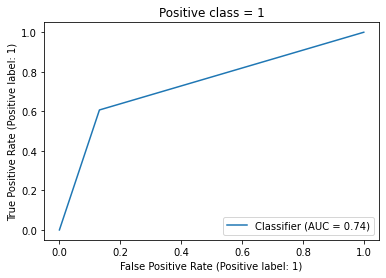

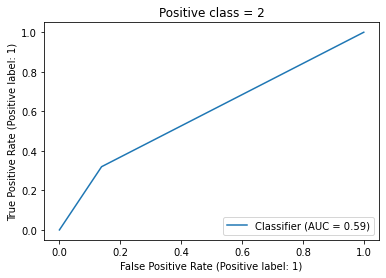

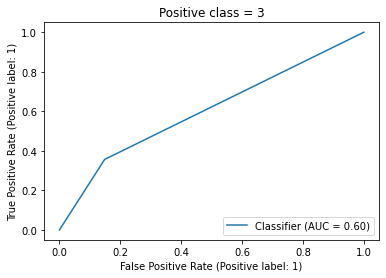

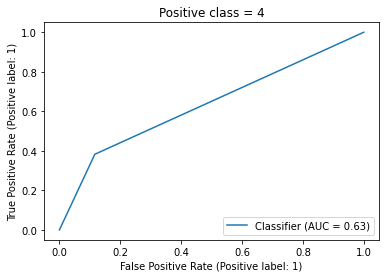

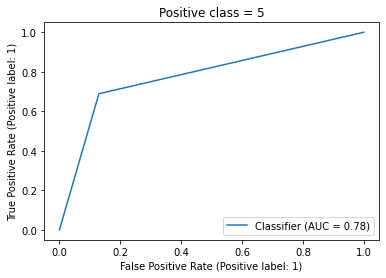

The mean AUC across all positive classes is: 0.669012975629133


In [89]:
alpha = 0.1
max_its = 1000
regularization = 'l2'

final_model_multiclass = MultiClassClassifier(x_train, x_test, y_train, y_test, alpha, max_its, regularization)
final_model_multiclass.run()

<h2>K-Means Clustering</h2>

<h3>Feature Engineering</h3>

For k-means clustering, I didn't want to use the text analysis I had used for the classifiers. Instead of word counts, I wanted to use something more potent: sentiment analysis. The cell below is the sentiment analysis I conducted using the Hugging Face library. Each product review in the test dataset corresponds to one value, reflecting sentiment valence (+/-) and confidence (out of 1.0). I wrote the data to a separate CSV because it takes a while to run. That CSV file is included in this submission's zip file. 

In [ ]:
# Perform sentiment analysis on each review in the Test dataset
# Outputs a CSV file with one entry for each product review, in the order of the training dataset
# Each value in the CSV reflects confidence and sentiment
# The valence (+/-) of the value = sentiment (positive or negative)
# The actual value = confidence (0 = 0%, 1.0 = 100%)

sentiments, iterable, labels = [], [], []
batch_size, text_size = 500, 512

# Import sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Analyze each product review
for i in range(0, len(test)):
    
    datapoint = test['reviewText'][i][:text_size]
    
    iterable.append(datapoint)
    
    if len(iterable) == batch_size:
    
        out = sentiment_pipeline(iterable)
        sentiments.append(out)
        iterable = []
        
    if len(train) - i == 1:
        
        out = sentiment_pipeline(iterable)
        sentiments.append(out)
        break
        
# Combine the sentiment and confidence into a single value
flat = [item for sublist in sentiments for item in sublist]

for item in flat:
    
    if item['label'] == 'POSITIVE':
        labels.append(item['score'])
        
    else:
        labels.append(-1 * item['score'])

# Write to CSV file in the current directory
df = pd.DataFrame(labels, columns = ['sentiment'])
df.to_csv('sentiment_analysis_test.csv')

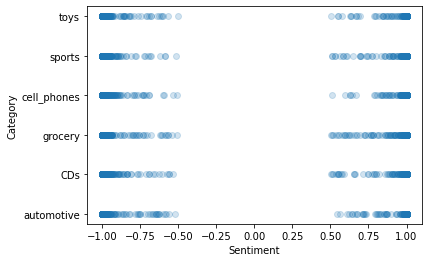

In [51]:
test_data_sentiment = pd.read_csv('sentiment_analysis_test.csv')
sentiment_data = np.array(test_data_sentiment.iloc[: , 1:])
actual_labels = np.array(test['category'])

plt.scatter(sentiment_data, list(test['category']), alpha=0.2)
plt.ylabel('Category'), plt.xlabel('Sentiment')
plt.show()

The goal of k-means clustering in this case is to group each product review into one of six clusters (the number of product categories). So, I wanted to look at how strongly the sentiment of a review correlates with its product category. It does not seem to reflect category very strongly, but it is the most potent and consistent data in the dataset, therefore I will use it in my k-means clustering model.

<h3>K-Means Model</h3>

In [52]:
# Build the k-means clustering model using sklearn's library
def build_model(data, n_clusters):
    
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data)
    
    return kmeans

# Place new data into one of the model's six clusters
def predict(model, data):
    
    return model.fit_predict(data)

# Calculate the Silhouette score and Rand index for the model
def evaluate(data, y_predicted, y_actual):
    
    ss = silhouette_score(data, y_predicted)
    rs = rand_score(y_predicted, y_actual)
    
    print('The silhouette score of this clustering model is ' + str(ss))
    print('The Rand Index score of this clustering model is ' + str(rs))
    
    return ss, rs

In [59]:
# Build a K-means model using 
model = build_model(sentiment_data, 6)
predicted_labels = predict(model, sentiment_data)
ss, rs = evaluate(sentiment_data, predicted_labels, actual_labels)

The silhouette score of this clustering model is 0.8918696672900226
The Rand Index score of this clustering model is 0.5495503692178508


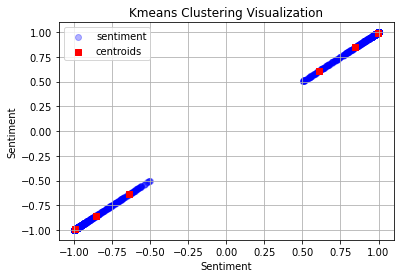

In [60]:
# Visualize the centroids of each cluster relative to the test data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(sentiment_data, sentiment_data, c='b', alpha=0.3, label='sentiment')
ax.scatter(model.cluster_centers_, model.cluster_centers_, c='r', marker='s', label='centroids')
plt.title('Kmeans Clustering Visualization'), plt.xlabel('Sentiment'), plt.ylabel('Sentiment')
plt.legend(loc='upper left')
plt.grid()
plt.show()

The silhouette score and Rand index score of the k-means model are printed above. Also above is a visualization of the k-means model. The input data was one-dimensional, so each datapoint falls along a line (hence the linear relationship seen in the graph). The k-means model iterates over the data to place centroids at the center of each cluster it identifies. These centroids are the red dots seen on top of the blue test datapoints.